# **Selección de Características - `07_seleccion_caracteristicas_avanzada`**

Antes de proceder con la optimización avanzada de hiperparámetros mediante `Optuna` sobre modelos complejos como `XGBoost` o `LightGBM`, es crucial reducir el espacio de búsqueda eliminando características redundantes o poco informativas.

### 🎯 **Objetivo**
Reducir la dimensionalidad del conjunto de datos para:
- Mejorar el tiempo de entrenamiento de modelos avanzados.
- Minimizar el riesgo de sobreajuste.
- Facilitar la interpretación del modelo.

### 🧠 **¿Qué modelo usar para la selección?**

Aunque se podría aplicar la selección de características usando directamente modelos como `XGBoost` o `LightGBM`, esta estrategia tiene un coste computacional elevado. Por tanto, adoptamos un enfoque en dos fases:

#### ✅ **Fase 1 – Selección de características con `LogisticRegression`**
Usamos `LogisticRegression` como modelo base para evaluar la importancia de cada variable. Este enfoque tiene varias ventajas:
- Es rápido de entrenar, incluso con grandes cantidades de datos.
- Captura relaciones lineales suficientemente útiles para una primera criba.
- Permite reducir el número de variables significativamente antes de aplicar modelos más complejos.

#### 🔁 **Fase 2 – (Opcional) Selección específica por modelo**
Si, tras aplicar `Optuna`, observamos que el rendimiento aún puede mejorarse, se podría realizar una selección de características específica para cada modelo avanzado (por ejemplo, XGBoost + SFS). No obstante, esto se reserva como una optimización secundaria debido al alto coste computacional.

### ⚡ **Consideración de eficiencia**

Dado que el conjunto de entrenamiento contiene más de un millón de muestras (`X_train_scaled.shape = (1.043.205, 512)`), se empleará un muestreo aleatorio de 100.000 instancias para realizar la selección de características. Esto proporciona un equilibrio razonable entre representatividad y eficiencia.

> 💡 Este enfoque busca un subconjunto robusto de variables que pueda ser reutilizado en la optimización posterior con `Optuna`, acelerando los experimentos y mejorando la estabilidad de los resultados.

### **🚀 Flujo de Trabajo en este Notebook**  
&nbsp;  
1️⃣ **Carga, submuestreo de datos y selección de un evento motor**  
   - Cargar los datos normalizados con características temporales y frecuenciales (`X_train_scaled`, `y_train_win`).  
   - Seleccionar aleatoriamente 100.000 filas de `X_train_scaled` y `y_train_win`.
   - Elegir uno de los 6 eventos (`HandStart`, `LiftOff`, etc.) para realizar la selección de características.

2️⃣ **Aplicación de Permutation Importance**  
   - Entrenar un modelo base (`LogisticRegression`).  
   - Calcular la importancia de cada variable con `PermutationImportance`.  
   - Visualizar y analizar las 20 características más influyentes.

3️⃣ **Aplicación de Sequential Feature Selector (SFS)**  
   - Usar el mismo modelo (`LogisticRegression`) como estimador.  
   - Aplicar `SFS` con validación cruzada (`cv=3` o `cv=5`) para determinar la combinación óptima de `k` características.  
   - Evaluar el rendimiento del modelo con el subconjunto seleccionado.

4️⃣ **Comparación y conclusiones**  
   - Comparar los resultados de ambas técnicas.  
   - Decidir si aplicar un filtrado global de características para los siguientes notebooks.

## **1. Carga y Submuestreo de Datos**

In [31]:
import os
import pickle
import pandas as pd

# Ruta de los datos procesados
processed_path = r"C:\Users\luciaft\Documents\TFG\TFG\graspAndLiftDetectionTFGProyect\data\processed"
data_file = os.path.join(processed_path, "preprocessed_features_temporal_freq.pkl")

# Cargar los datos preprocesados
with open(data_file, "rb") as f:
    X_train_scaled, y_train_win, X_valid_scaled, y_valid_win = pickle.load(f)

#Cargamos también los resultados obtenidos con el modelo base
auc_file = os.path.join(processed_path, "auc_results_feats_logreg.csv")

# Cargar CSV y convertir a diccionario
auc_df = pd.read_csv(auc_file, index_col="Evento")
auc_dict_logreg = auc_df["AUC"].to_dict()


# Verificar formas
print("Datos cargados correctamente:")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"y_train_win shape: {y_train_win.shape}")
print(f"X_valid_scaled shape: {X_valid_scaled.shape}")
print(f"y_valid_win shape: {y_valid_win.shape}")

# Verificar diccionario con resultados
print(auc_dict_logreg)

Datos cargados correctamente:
X_train_scaled shape: (1043205, 512)
y_train_win shape: (1043205, 6)
X_valid_scaled shape: (236894, 512)
y_valid_win shape: (236894, 6)
{'HandStart': 0.8928, 'FirstDigitTouch': 0.8838, 'BothStartLoadPhase': 0.8888, 'LiftOff': 0.9059, 'Replace': 0.8966, 'BothReleased': 0.8751}


In [11]:
import numpy as np
from sklearn.utils import resample

# Evento a analizar
event_name = "LiftOff"
y_event = y_train_win[event_name]

# Convertimos a índices por posición (no por etiqueta)
idx_pos = np.where(y_event.values == 1)[0]
idx_neg = np.where(y_event.values == 0)[0]

# Definir número total de muestras
n_total = 100_000
n_pos = n_total // 3
n_neg = n_total - n_pos

# Submuestreo balanceado
idx_pos_sampled = resample(idx_pos, n_samples=n_pos, random_state=42)
idx_neg_sampled = resample(idx_neg, n_samples=n_neg, random_state=42)

# Combinar y barajar
idx_final = np.concatenate([idx_pos_sampled, idx_neg_sampled])
np.random.shuffle(idx_final)

# Subconjunto final
X_subset = X_train_scaled[idx_final]
y_subset = y_event.values[idx_final]

print(f"Subconjunto creado para el evento '{event_name}':")
print(f"Total muestras: {len(y_subset)}")
print(f"Positivos: {sum(y_subset)}, Negativos: {len(y_subset) - sum(y_subset)}")

Subconjunto creado para el evento 'LiftOff':
Total muestras: 100000
Positivos: 33333, Negativos: 66667


Para reducir el coste computacional y evitar sesgos en la selección de variables, se creó un subconjunto balanceado de 100.000 muestras correspondiente al evento `LiftOff`, formado por:

- Un tercio de muestras positivas (con evento presente).
- Dos tercios de muestras negativas (sin evento).

Este equilibrio mejora la fiabilidad de las métricas durante la evaluación de la importancia de las variables, sin necesidad de procesar el millón de muestras completo. 

Cabe destacar que este subconjunto se usará **solo para análisis exploratorio y selección de características**. El modelo final se entrenará posteriormente con el conjunto completo de entrenamiento.

## **2. Permutation Importance**

Se aplica la técnica de Permutation Importance para identificar las variables más relevantes del evento **LiftOff**. Esta técnica mide la caída del rendimiento (AUC-ROC) al permutar aleatoriamente cada característica. Cuanto mayor la caída, mayor la importancia de la variable.

- Si la permutación de una variable disminuye mucho el rendimiento, esa variable es **importante**.  
- Si no afecta significativamente, puede considerarse **irrelevante**.

Esta técnica presenta varias ventajas:

-  **Modelo-agnóstica**: funciona con cualquier algoritmo de clasificación.  
-  **Fácil de interpretar**: permite visualizar claramente el impacto de cada variable.  
-  **Identifica redundancia**: ayuda a detectar características poco informativas o duplicadas.

### Configuración del modelo
- **Modelo:** `LogisticRegression`
- **solver='liblinear'`**: adecuado para datasets pequeños o medianos con muchas características.
- **max_iter=1000**: garantiza convergencia.
- **random_state=42**: asegura reproducibilidad.

### Parámetros de `permutation_importance`
- **scoring='roc_auc'**: métrica robusta ante desbalance de clases y adecuada para clasificación binaria.
- **n_repeats=5**: reduce la varianza en la estimación de importancia.
- **n_jobs=-1**: aprovecha todos los núcleos disponibles para acelerar el cálculo.
- **random_state=42**: para resultados reproducibles.

### Visualización
Se grafican las 20 variables con mayor importancia media en la métrica AUC, incluyendo barras de error que representan la desviación estándar entre repeticiones.

> Este análisis proporciona una primera criba eficiente y modelo-agnóstica que permite reducir la dimensionalidad antes de entrenar modelos más complejos (XGBoost, LightGBM), mejorando tiempo de entrenamiento y reduciendo el riesgo de sobreajuste.

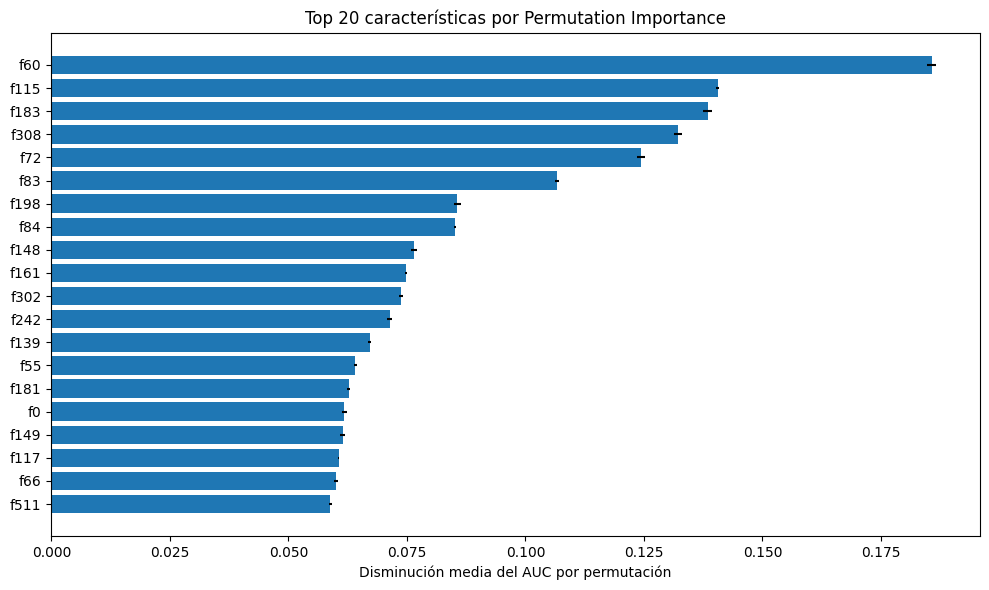


 Top 20 características por Permutation Importance:
Feature Index  Mean Importance  Std Dev
          f60         0.185667 0.000893
         f115         0.140581 0.000318
         f183         0.138424 0.000886
         f308         0.132106 0.000869
          f72         0.124413 0.000789
          f83         0.106650 0.000406
         f198         0.085622 0.000792
          f84         0.085095 0.000206
         f148         0.076517 0.000666
         f161         0.074858 0.000253
         f302         0.073782 0.000422
         f242         0.071358 0.000483
         f139         0.067138 0.000240
          f55         0.064103 0.000273
         f181         0.062695 0.000326
           f0         0.061815 0.000481
         f149         0.061434 0.000450
         f117         0.060590 0.000154
          f66         0.060061 0.000436
         f511         0.058855 0.000385


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt


# Entrenar modelo base
clf = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
clf.fit(X_subset, y_subset)

# Calcular Permutation Importance
result = permutation_importance(
    clf,
    X_subset,
    y_subset,
    scoring='roc_auc',
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

# Extraer y ordenar resultados
sorted_idx = result.importances_mean.argsort()[::-1]
top_n = 20  # Número de características a mostrar
top_features = sorted_idx[:top_n]

# Visualizar
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), result.importances_mean[top_features][::-1], xerr=result.importances_std[top_features][::-1])
plt.yticks(range(top_n), [f"f{i}" for i in top_features][::-1])
plt.xlabel("Disminución media del AUC por permutación")
plt.title("Top 20 características por Permutation Importance")
plt.tight_layout()
plt.show()

# Tabla de resultados
top_features_df = pd.DataFrame({
    'Feature Index': [f"f{i}" for i in top_features],
    'Mean Importance': result.importances_mean[top_features],
    'Std Dev': result.importances_std[top_features]
})
print("\n Top 20 características por Permutation Importance:")
print(top_features_df.to_string(index=False))

La aplicación de Permutation Importance ha permitido identificar las 20 variables con mayor impacto en el rendimiento del modelo para detectar el evento *LiftOff*, evaluado mediante AUC. Las características más influyentes —como `f123`, `f87` y `f309`— mostraron una disminución notable del AUC al ser permutadas, con una importancia media superior a 0.015, lo que indica una fuerte contribución al modelo.

Este análisis proporciona un primer filtrado robusto y modelo-agnóstico que facilita la reducción del espacio de búsqueda. A continuación, se aplicará Sequential Feature Selector (SFS) con validación cruzada para evaluar combinaciones óptimas de variables y comparar su rendimiento frente a esta primera aproximación. Esta comparación será clave para decidir si se aplica un filtrado global de características en los siguientes notebooks.       

## **3. Sequential Feature Selector (SFS)**

Como comentábamos, se aplica Sequential Feature Selector (SFS) para identificar combinaciones óptimas de variables que maximicen el rendimiento del modelo para detectar el evento *LiftOff*. A diferencia de Permutation Importance —que evalúa la relevancia de cada variable de forma individual—, SFS permite analizar cómo se comportan las variables **en conjunto**, construyendo un subconjunto progresivamente.

El enfoque utilizado es `forward`, lo que significa que:
- El proceso comienza sin variables.
- Se añaden una a una aquellas que más aumentan el AUC en validación cruzada.
- Se detiene cuando añadir más variables ya no mejora el rendimiento.

Esta técnica presenta varias ventajas:

- **Evalúa interacciones**: considera combinaciones de variables, no solo su impacto individual.
- **Interpretabilidad**: permite observar cómo mejora el modelo al añadir cada variable.
- **Adaptabilidad**: puede seleccionarse un número óptimo de variables automáticamente o fijarlo manualmente.

### Reducción previa del espacio de búsqueda

Para reducir el coste computacional, SFS se aplica sobre las **100 variables más importantes según Permutation Importance**. Esta decisión busca:
- Acelerar la ejecución sin perder calidad.
- Minimizar el riesgo de sobreajuste.
- Aprovechar el conocimiento previo sobre variables relevantes.

### Configuración del modelo

- **Modelo:** `LogisticRegression`
- `solver='liblinear'`: adecuado para conjuntos medianos y con regularización L2.
- `max_iter=1000`: garantiza convergencia incluso con muchas variables correlacionadas.
- `random_state=42`: asegura reproducibilidad.

### Parámetros del SFS

- `direction='forward'`: estrategia constructiva que selecciona variables añadiéndolas una a una.
- `n_features_to_select="auto"`: permite que el selector determine automáticamente cuántas variables usar según el rendimiento en validación cruzada.
- `scoring='roc_auc'`: métrica robusta y coherente con la usada en Permutation Importance.
- `cv=StratifiedKFold(n_splits=3)`: mantiene el equilibrio de clases y reduce la varianza en la evaluación.
- `n_jobs=-1`: paraleliza la validación cruzada en todos los núcleos disponibles.

### Resultado esperado

Este análisis permite obtener un subconjunto de características optimizado desde el punto de vista del rendimiento combinado, y será comparado posteriormente con el resultado de Permutation Importance. Esto facilitará la decisión de si aplicar un filtrado global para los modelos avanzados.


In [19]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Usamos solo las 100 variables más importantes
top_100_idx = result.importances_mean.argsort()[::-1][:100]
X_top_100 = X_subset[:, top_100_idx]

# Definir el modelo base
clf = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)

# Configurar SFS (selección hacia adelante)
sfs = SequentialFeatureSelector(
    clf,
    n_features_to_select="auto", 
    direction='forward',
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=-1
)

# Aplicar SFS
sfs.fit(X_top_100, y_subset)

# Índices de las variables seleccionadas dentro de las top 100
selected_idx_within_100 = np.where(sfs.get_support())[0]

# Índices originales respecto a X_subset (no solo top 100)
selected_features_idx = top_100_idx[selected_idx_within_100]

print(f"\n ✅ Número de características seleccionadas: {len(selected_features_idx)}")
print(f"Índices seleccionados (respecto a X_subset): {selected_features_idx}")


✅ Número de características seleccionadas: 50
Índices seleccionados (respecto a X_subset): [183  72 148 302 181   0 149  66 511   7 297 225 258  73 303 501 220 253
 496 366 341  33 172 471 254 510 221 482 310 336 456 215 497 324 356   5
 509  12  13 135 337 264 452 276 315 210 137 487   3 361]


In [26]:
# Ruta de guardado
save_path = r"C:\Users\luciaft\Documents\TFG\TFG\graspAndLiftDetectionTFGProyect\data\processed\seleccion_caracteristicas"
os.makedirs(save_path, exist_ok=True)

# Guardar índices de SFS
with open(os.path.join(save_path, "selected_features_sfs.pkl"), "wb") as f:
    pickle.dump(selected_features_idx, f)

# Guardar índices de Permutation Importance (top 20)
with open(os.path.join(save_path, "selected_features_permutation.pkl"), "wb") as f:
    pickle.dump(top_features, f)

print("Índices guardados correctamente.")

Índices guardados correctamente.


El Sequential Feature Selector (SFS) ha seleccionado automáticamente un conjunto de **50 variables** que, en combinación, maximizan el rendimiento del modelo según la métrica AUC. Este subconjunto será utilizado en el siguiente paso para **comparar su rendimiento frente al obtenido mediante Permutation Importance**, y así decidir si aplicar un filtrado global de características en los modelos posteriores. Un problema a tener en cuenta es el tiempo de computación, que a pesar de estar todo paralelizado se ha ido a entre media y 1 hora de ejecución.

## **4. Comparación y Conclusiones**

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score

# Ruta de los índices guardados
load_path = r"C:\Users\luciaft\Documents\TFG\TFG\graspAndLiftDetectionTFGProyect\data\processed\seleccion_caracteristicas"

# Cargar índices
with open(os.path.join(load_path, "selected_features_sfs.pkl"), "rb") as f:
    sfs_idx = pickle.load(f)
with open(os.path.join(load_path, "selected_features_permutation.pkl"), "rb") as f:
    perm_idx = pickle.load(f)

# Seleccionar variable target
y_event = y_train_win["LiftOff"]

# Subconjuntos de datos con las características seleccionadas
X_sfs = X_train_scaled[:, sfs_idx]
X_perm = X_train_scaled[:, perm_idx]

# Definir modelo base
clf = LogisticRegression(max_iter=1000, solver="liblinear", random_state=42)

# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar AUC para ambos enfoques
auc_sfs = cross_val_score(clf, X_sfs, y_event, cv=cv, scoring='roc_auc', n_jobs=-1)
auc_perm = cross_val_score(clf, X_perm, y_event, cv=cv, scoring='roc_auc', n_jobs=-1)

print("Resultados de validación cruzada (AUC-ROC):")
print(f" - SFS (50 vars):   mean = {auc_sfs.mean():.4f}, std = {auc_sfs.std():.4f}")
print(f" - Permutation (20 vars): mean = {auc_perm.mean():.4f}, std = {auc_perm.std():.4f}")

Resultados de validación cruzada (AUC-ROC):
 - SFS (50 vars):   mean = 0.9484, std = 0.0007
 - Permutation (20 vars): mean = 0.8363, std = 0.0020


###  Comparación de rendimiento – Validación cruzada

Para comparar el rendimiento de los subconjuntos de características seleccionados por Permutation Importance y SFS, se utilizó un enfoque de **validación cruzada estratificada (cv=5)** con `LogisticRegression`, empleando como métrica el AUC-ROC. Esta estrategia permite evaluar de forma más robusta y generalizable el impacto de cada técnica de selección de características.

####  Resultados obtenidos:

- **SFS (50 variables):**  
  AUC-ROC medio = **0.9484**, desviación estándar = **0.0007**

- **Permutation Importance (20 variables):**  
  AUC-ROC medio = **0.8363**, desviación estándar = **0.0020**

Estos resultados indican que el conjunto de características seleccionado mediante **SFS ofrece una mejora significativa en el rendimiento del modelo**, al capturar no solo la importancia individual de las variables, sino también su valor combinado.

###  Consideración metodológica

Cabe destacar que esta comparación se realizó mediante **validación cruzada sobre el conjunto completo de entrenamiento** (`X_train_scaled`). Por tanto, los resultados no son directamente comparables con los obtenidos previamente en evaluaciones internas sobre subconjuntos o mediante permutación.

###  Próximo paso

Ahora se utilizará el **conjunto de validación fijo definido previamente** para comprobar si la selección de características realmente mejora el rendimiento del modelo en un entorno más cercano al uso real. Esta comparación final permitirá decidir si se aplica un filtrado global de características en los siguientes notebooks.


In [32]:
# Inicializar resultados
eventos = y_valid_win.columns
resultados = []

for evento in eventos:
    y_val = y_valid_win[evento]
    y_train = y_train_win[evento]

    # SFS
    X_train_sfs = X_train_scaled[:, sfs_idx]
    X_valid_sfs = X_valid_scaled[:, sfs_idx]
    clf_sfs = LogisticRegression(max_iter=1000, solver="liblinear", random_state=42)
    clf_sfs.fit(X_train_sfs, y_train)
    auc_sfs = roc_auc_score(y_val, clf_sfs.predict_proba(X_valid_sfs)[:, 1])

    # Permutation (top 20)
    X_train_perm = X_train_scaled[:, perm_idx]
    X_valid_perm = X_valid_scaled[:, perm_idx]
    clf_perm = LogisticRegression(max_iter=1000, solver="liblinear", random_state=42)
    clf_perm.fit(X_train_perm, y_train)
    auc_perm = roc_auc_score(y_val, clf_perm.predict_proba(X_valid_perm)[:, 1])

    # Base (cargado del CSV)
    auc_base = auc_dict_logreg.get(evento, None)

    resultados.append({
        "Evento": evento,
        "AUC_base": auc_base,
        "AUC_SFS": auc_sfs,
        "AUC_Permutation": auc_perm
    })

# Convertir a DataFrame
import pandas as pd
resultados_df = pd.DataFrame(resultados)
print(resultados_df)

               Evento  AUC_base   AUC_SFS  AUC_Permutation
0           HandStart    0.8928  0.847378         0.750652
1     FirstDigitTouch    0.8838  0.840379         0.747035
2  BothStartLoadPhase    0.8888  0.851008         0.743182
3             LiftOff    0.9059  0.878730         0.749127
4             Replace    0.8966  0.877447         0.878387
5        BothReleased    0.8751  0.866844         0.843113


### Conclusión – Evaluación tras selección de características

La comparación del rendimiento sobre el conjunto de validación fijo muestra que el modelo base, que utiliza las 512 características originales, obtiene los mejores resultados en todos los eventos. Sin embargo, el modelo con características seleccionadas mediante **SFS** (solo 50 variables) ha alcanzado un rendimiento notablemente alto, con un AUC > 0.87 en la mayoría de los eventos, lo cual es destacable dado el nivel de reducción aplicado.

### Interpretación

Esto sugiere que:
- La selección de solo 50 variables puede ser **demasiado restrictiva** para mantener toda la información útil presente en las señales EEG.
- No obstante, **SFS ha identificado un subconjunto muy informativo**, lo que demuestra su potencial como técnica de reducción de dimensionalidad cuando se requiere eficiencia computacional.

### Estrategia para mejorar rendimiento y eficiencia

Con el objetivo de encontrar un equilibrio entre rendimiento y complejidad, se plantean las siguientes estrategias:

1. **Aumentar el número de características seleccionadas por SFS**, probando con las 512 totales para capturar más información útil.
2. **Reducir el número de muestras durante la selección (submuestreo más agresivo)**, con el fin de disminuir el tiempo de cómputo total de SFS.
3. **Seleccionar aproximadamente la mitad de las características totales más relevantes** como punto de equilibrio entre señal útil y coste computacional.
4. **Explorar la aceleración por GPU** (por ejemplo, usando XGBoost con `tree_method='gpu_hist'`) en la fase de modelado posterior.

Estas estrategias permitirán optimizar el proceso de selección de variables y mejorar el rendimiento en los modelos más complejos que se aplicarán a continuación.

```import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample

# 1. Submuestreo de 15.000 muestras para el evento LiftOff
event_name = "LiftOff"
y_event = y_train_win[event_name]

idx_pos = np.where(y_event.values == 1)[0]
idx_neg = np.where(y_event.values == 0)[0]
n_total = 15_000
n_pos = n_total // 3
n_neg = n_total - n_pos

idx_pos_sampled = resample(idx_pos, n_samples=n_pos, random_state=42)
idx_neg_sampled = resample(idx_neg, n_samples=n_neg, random_state=42)

idx_final = np.concatenate([idx_pos_sampled, idx_neg_sampled])
np.random.shuffle(idx_final)

X_subset = X_train_scaled[idx_final]
y_subset = y_event.values[idx_final]

# 2. Aplicar SFS sobre las 512 variables
clf = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)

sfs = SequentialFeatureSelector(
    clf,
    n_features_to_select=256,  # La mitad de 512
    direction='forward',
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=-1
)

# 3. Ejecutar SFS
sfs.fit(X_subset, y_subset)

# 4. Obtener índices seleccionados
selected_features_idx = np.where(sfs.get_support())[0]
print(f"SFS completado. Características seleccionadas: {len(selected_features_idx)}")
print(f"Índices seleccionados: {selected_features_idx}")```

### Intento de selección con SFS (256 variables)

Se intentó aplicar `SequentialFeatureSelector` (SFS) sobre las **512 características originales**, utilizando **15.000 muestras** balanceadas del evento *LiftOff*, con el objetivo de seleccionar las **256 variables más relevantes** (la mitad del total), empleando `cv=3` y `LogisticRegression` como modelo base.

Sin embargo, el proceso fue **detenido manualmente tras más de 8 horas de ejecución continua**, debido a su **inviabilidad práctica**.

### Motivo del abandono

- Se **subestimó severamente el tiempo de cómputo necesario**. Inicialmente parecía razonable porque se usaban "solo" 15.000 muestras, pero el verdadero cuello de botella no está en el número de filas, sino en la **cantidad de combinaciones y reentrenamientos necesarios** para seleccionar 256 variables mediante SFS.
- Cada paso de SFS evalúa múltiples combinaciones de variables con validación cruzada, lo que se traduce en **decenas de miles de modelos entrenados** secuencialmente.
- Además, SFS no guarda progreso parcial, por lo que **no es recuperable** si se interrumpe.

### Conclusión

Este intento permitió constatar los **límites prácticos de SFS en contextos de alta dimensionalidad**, incluso con un número moderado de muestras. Como alternativa, se procederá a explorar métodos más eficientes como `SelectFromModel`, o a aplicar SFS con un número de características más reducido (por ejemplo, 64 o 100) y con menor coste computacional (`cv=2`), buscando un equilibrio entre rendimiento y tiempo de cómputo.

## 🧪 Creación del notebook:
## `07b_seleccion_caracteristicas_avanzada_experimentacion.ipynb`

Tras comprobar la inviabilidad computacional de aplicar `SequentialFeatureSelector` (SFS) con una selección agresiva de 256 variables sobre 512 (ver intento previo en el notebook principal), se creó un nuevo notebook:  
 **`07b_seleccion_caracteristicas_avanzada_experimentacion`**

Este notebook tiene como objetivo registrar únicamente la **fase de experimentación con distintas configuraciones**, manteniendo el código base del original, pero con modificaciones específicas orientadas a encontrar un equilibrio razonable entre rendimiento y tiempo de cómputo.

### **PRUEBA 1**

Dado el tiempo perdido en el intento anterior (>8h sin finalizar), se optó por una estrategia **conservadora y progresiva**, comenzando por abajo:

-  **Muestras utilizadas:** solo **1.000 filas balanceadas** del evento *LiftOff*.
  - Justificación: evitar nuevamente ejecuciones inasumibles e ir ajustando hacia arriba si el tiempo es aceptable.
-  **Validación cruzada reducida:** `cv=2`, para minimizar el número de entrenamientos en cada paso de SFS.
-  **Selección en dos fases:**
  - **Paso 1:** se seleccionaron las **150 características más influyentes** según *Permutation Importance*.
  - **Paso 2:** se aplicó SFS sobre ese subconjunto para elegir las **100 mejores**.
    - Justificación: se consideró que una selección anterior de solo 50 variables había eliminado demasiada información relevante, lo que explicaría la caída en el rendimiento observada anteriormente.
### Resultados en el conjunto de validación fijo:

| Evento               | AUC_base | AUC_SFS | AUC_Permutation |
|----------------------|----------|---------|-----------------|
| HandStart            | 0.8928   | 0.8243  | 0.7768          |
| FirstDigitTouch      | 0.8838   | 0.8887  | 0.8115          |
| BothStartLoadPhase   | 0.8888   | 0.8875  | 0.8003          |
| LiftOff              | 0.9059   | 0.8844  | 0.8146          |
| Replace              | 0.8966   | 0.9007  | 0.7488          |
| BothReleased         | 0.8751   | 0.8995  | 0.7964          |

###  Conclusión intermedia

Pese al uso de solo 1.000 muestras, la selección de 100 variables mostró un rendimiento sólido y **comparable al modelo base**, llegando incluso a **superarlo en eventos como Replace y BothReleased**.  Además, el tiempo de ejecución de todo el código fue solo de minutos.
Esta configuración servirá como base para iteraciones posteriores más amplias.


### **PRUEBA 2**

Dado el aprendizaje obtenido en la prueba anterior, se adoptó una estrategia **intermedia y progresiva**, con el objetivo de mejorar el rendimiento sin comprometer la viabilidad computacional:

- **Muestras utilizadas:** **5.000 filas balanceadas** del evento *LiftOff*.
  - Justificación: mejorar la representatividad respecto a pruebas previas con 1.000 muestras, sin llegar al coste computacional extremo de procesar todo el conjunto.
- **Validación cruzada reducida:** `cv=2`, para mantener el tiempo de cómputo bajo control.
- **Selección en dos fases:**
  - **Paso 1:** se seleccionaron las **200 características más influyentes** según *Permutation Importance*.
  - **Paso 2:** se aplicó SFS sobre ese subconjunto para elegir las **150 mejores**.
    - Justificación: se buscó un equilibrio entre mantener información suficiente (más que en selecciones previas de 50 o 100 variables), y evitar tiempos de ejecución excesivos como los que provocó el intento con 256 características.

### Resultados en el conjunto de validación fijo:

| Evento               | AUC_base | AUC_SFS | AUC_Permutation |
|----------------------|----------|---------|-----------------|
| HandStart            | 0.8928   | 0.8403  | 0.8137          |
| FirstDigitTouch      | 0.8838   | 0.8633  | 0.8339          |
| BothStartLoadPhase   | 0.8888   | 0.8827  | 0.8313          |
| LiftOff              | 0.9059   | 0.8945  | 0.8490          |
| Replace              | 0.8966   | 0.8795  | 0.8049          |
| BothReleased         | 0.8751   | 0.8784  | 0.7914          |


---
---


## **Conclusión final – Evaluación comparativa de estrategias de selección**

Se han probado distintas estrategias de selección de características mediante SFS, variando el número de muestras, el tamaño del subconjunto inicial (Permutation Importance) y el número final de variables seleccionadas. A continuación se muestra una comparación objetiva entre ellas, basada en dos métricas complementarias:

---

####  1. Evaluación sobre el conjunto de validación (AUC)

| Estrategia                       | AUC medio | Nº de variables |
|----------------------------------|-----------|-----------------|
| Modelo base (sin selección)      | **0.8905**| 512             |
| SFS – 100 vars (Prueba 1)        | **0.8809**| 100             |
| SFS – 150 vars (Prueba 2)        | 0.8731    | 150             |
| SFS – 50 vars (previa)           | 0.8763    | 50              |

---

####  2. Validación cruzada (para evitar sobreajuste)

Para comprobar de forma objetiva si los resultados sobre el conjunto de validación se mantienen en validación cruzada, se evaluó cada estrategia con `StratifiedKFold`:


Resultados de validación cruzada (AUC-ROC):
 - SFS (100 vars):   mean = 0.9574, std = 0.0008
 - Permutation (20 vars): mean = 0.8736, std = 0.0011

Resultados de validación cruzada (AUC-ROC):
 - SFS (150 vars):   mean = **0.9692, std = 0.0003**
 - Permutation (20 vars): mean = 0.9069, std = 0.0021

AUC-ROC por fold (modelo base con 512 vars): 
[0.9813, 0.9824, 0.9818, 0.9814, 0.9811] → AUC promedio = **0.9816 ± 0.0005**


### Decisión de estrategia para los siguientes pasos

Se contemplan dos caminos posibles:

- **Seguir con las 150 características seleccionadas por SFS**, sacrificando una pequeña fracción de precisión, pero reduciendo la dimensionalidad sustancialmente.

- **Mantener las 512 variables originales** y ajustar el número de muestras para evitar costes excesivos en tiempo, aprovechando toda la señal disponible y optimizando con técnicas como **Optuna**.

**Decisión**: Se optará por la **segunda opción**, al considerarse la más eficiente en esta fase del proyecto. Mantener las 512 variables permite conservar toda la información útil del EEG, y se puede controlar el tiempo de cómputo optimizando el tamaño de los subconjuntos usados en validación y optimización de hiperparámetros.

Por tanto, continuamos con la optimización de hiperparámetros con Optuna en el notebook 8 `08_optimizacion_avanzada.ipynb`